#  Projet Machine Learning

### MONTARIOL MONTAGARD
Your link to the github page of the project

## 1) Sujet

L'objectif est de créer un modèle supervisé qui analysera la différence de prix entre le marché infra-journalier (Intraday) et le marché SPOT.

L'enjeu prioritaire est de prédire correctement le sens de l'écart plutôt que sa valeur exacte. Cette information directionnelle est cruciale pour optimiser les décisions d'achat sur le marché le plus avantageux.

### 1.1) Contexte

Dans le contexte de ses activités de trading d'énergie, Elmy souhaite développer un modèle prédictif pour comparer les prix de l'électricité entre deux marchés européens :

- Le marché SPOT : un système d'enchères où l'électricité est achetée la veille pour le lendemain
- Le marché Intraday : une bourse où les transactions d'électricité se font le jour même

L'objectif est d'anticiper quel marché proposera les prix les plus avantageux, permettant ainsi d'optimiser les décisions d'achat d'électricité.

### 1.2) Description des données

Variables explicatives (features)

DELIVERY_START : Date et heure de livraison de l'énergie
load_forecast : Prévision de la demande en électricité
coal_power_available : Puissance disponible des centrales à charbon
gas_power_available : Puissance disponible des centrales à gaz
nucelear_power_available : Puissance disponible des centrales nucléaires
wind_power_forecasts_average : Moyenne des prévisions de production éolienne
solar_power_forecasts_average : Moyenne des prévisions de production solaire
wind_power_forecasts_std : Écart-type des prévisions de production éolienne
solar_power_forecasts_std : Écart-type des prévisions de production solaire
predicted_spot_price : Prix prédit sur le marché SPOT

Variable cible (target)

spot_id_delta : Écart entre le prix Intraday et le prix SPOT

En régression : valeur numérique de la différence
En classification : variable binaire (1 si prix Intraday > prix SPOT, 0 sinon)

### 1.3) Description du benchmark

Le benchmark consiste à prédire systématiquement que les prix Intraday seront supérieurs aux prix SPOT, une approche basée sur l'observation historique. La performance sera mesurée par la Weighted Accuracy : proportion de prédictions correctes du sens de l'écart (positif/négatif), pondérée par la valeur absolue des écarts observés.

## 2) Problématique 

<span style="color:red; font-weight:bold">Quels facteurs permettent de prédire si le prix spot de l'électricité sera supérieur ou inférieur au prix intraday?</span>

## 3) Préparation des données

### 3.1) Importations des bibliothèques

#### Importation des bibliothèques

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import plotly.express as px
import scipy.stats as stats

### Importation des classes

Pour faciliter le pipeline de traitement des données, nous avons créer des classe qui va nous permettre de gérer les différentes étapes de la préparation des données. Cela nous permet de mieux structurer notre code et de le rendre plus lisible. Egalement, cela a été fait pour faciliter la réutilisation du code et le travail collaboratif.

In [2]:
from clusterer import Clusterer, ClusterType
from model import Model

##### Importation des données

### 3.2) Importation des données

In [3]:
# Import des data test

X_test = pd.read_csv('./data/df_imputed_test.csv')
Y_test = pd.read_csv('./data/y_test_binary.csv')

# Import des data train
X_train = pd.read_csv('./data/df_imputed_train.csv')
Y_train = pd.read_csv('./data/y_train_binary.csv')

In [4]:
X_test['DELIVERY_START'] = pd.to_datetime(X_test['DELIVERY_START'], utc=True)
Y_test['DELIVERY_START'] = pd.to_datetime(Y_test['DELIVERY_START'], utc=True)
X_train['DELIVERY_START'] = pd.to_datetime(X_train['DELIVERY_START'], utc=True)
Y_train['DELIVERY_START'] = pd.to_datetime(Y_train['DELIVERY_START'], utc=True)

# Nos dfs n'ont pas la même taille, il y a un léger décallage qu'on élimine en se basant sur les DELIVERY_START
Y_train = Y_train[Y_train['DELIVERY_START'].isin(X_train['DELIVERY_START'])]

## 4) Notre notebook d'imputation

Nous avons créer un notebook d'imputation qui va nous permettre de gérer les différentes étapes de la préparation des données. Je renvois alors le lecteur à ce notebook. Il couvre notamment les parties 3.3 et 4. qui étaient initialement dans ce notebook.

## 5) Sélection du modèle

##### **Création et Entrainement du modèle**

In [5]:
X_train = X_train.drop(['DELIVERY_START'], axis=1)
X_test = X_test.drop(['DELIVERY_START'], axis=1)
Y_train = Y_train.drop(['DELIVERY_START'], axis=1)
Y_test = Y_test.drop(['DELIVERY_START'], axis=1)

## Notre Benchmark : Modèle Logistique simple

In [6]:
def calculate_p_values(model, X):
    """
    Calcule les p-values des coefficients d'un modèle de régression logistique

    Paramètres:
    -----------
    model : modèle de régression logistique ajusté
    X : matrice des features

    Retourne:
    ---------
    p_values : array des p-values pour chaque coefficient
    """
    # Matrice de covariance des coefficients
    coef_var = np.linalg.inv(np.dot(X.T, X))

    # Écart-type des coefficients
    se = np.sqrt(np.diag(coef_var))

    # Statistique de Wald
    z_scores = model.coef_[0] / se

    # Calcul des p-values (test bilatéral)
    p_values = [2 * (1 - stats.norm.cdf(abs(z))) for z in z_scores]

    return p_values

In [7]:
# Création et entraînement du modèle
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, Y_train)

# Prédictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Évaluation du modèle

accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

balanced_acc = balanced_accuracy_score(Y_test, y_pred)
print(f"Balanced Accuracy: {balanced_acc:.4f}")

Accuracy: 0.5304
Balanced Accuracy: 0.5018


## Modèle avec features significatives

In [8]:
model_initial = LogisticRegression(random_state=42, max_iter=1000)
model_initial.fit(X_train, Y_train)

# Calculer les p-values
p_values = calculate_p_values(model_initial, X_train)

# Créer un DataFrame des résultats
resultats_significativite = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model_initial.coef_[0],
    'P-Value': p_values
})

# Trier par p-value
resultats_significativite_tries = resultats_significativite.sort_values('P-Value')

# Sélectionner les features significatives à 5%
features_significatives = resultats_significativite_tries[resultats_significativite_tries['P-Value'] <= 0.05]

print("Features significatives à 5% :")
print(features_significatives)

# Sélectionner les colonnes significatives
colonnes_significatives = features_significatives['Feature'].tolist()

# Préparer les données avec uniquement les features significatives
X_train_significatif = X_train[colonnes_significatives]
X_test_significatif = pd.DataFrame(X_test, columns=X_test.columns)[colonnes_significatives]

# Entraîner un nouveau modèle avec uniquement les features significatives
model_significatif = LogisticRegression(random_state=42, max_iter=1000)
model_significatif.fit(X_train_significatif, Y_train)

# Évaluer le modèle
y_pred = model_significatif.predict(X_test_significatif)
accuracy = accuracy_score(Y_test, y_pred)
balanced_acc_bench = balanced_accuracy_score(Y_test, y_pred)

Features significatives à 5% :
                 Feature  Coefficient       P-Value
33   spot_id_delta_lag_2     0.576583  0.000000e+00
34   spot_id_delta_lag_3     0.395025  0.000000e+00
32   spot_id_delta_lag_1     2.404985  0.000000e+00
49  spot_id_delta_lag_18     0.186489  6.374901e-13
11                   Apr    -0.347960  6.767920e-13
21                is_day     0.175077  2.276357e-11
40   spot_id_delta_lag_9     0.170504  5.917198e-09
48  spot_id_delta_lag_17    -0.155885  8.619628e-08
38   spot_id_delta_lag_7     0.154140  1.429836e-07
9                    Feb    -0.330357  1.316223e-06
47  spot_id_delta_lag_16     0.104730  3.401906e-04
16                   Sep    -0.254050  3.574516e-04
39   spot_id_delta_lag_8     0.096618  9.751082e-04
42  spot_id_delta_lag_11     0.094365  1.279950e-03
15                   Aug    -0.225411  1.603538e-03
19                   Dec    -0.175481  4.227614e-03
17                   Oct    -0.138195  1.200771e-02
14                   Jul    -0.15

In [9]:
print("\nPerformances du modèle avec features significatives :")
print(f"Accuracy: {accuracy:.4f}")
print(f"Balanced Accuracy: {balanced_acc_bench:.4f}")


Performances du modèle avec features significatives :
Accuracy: 0.5316
Balanced Accuracy: 0.5024


- Pour notre projet de prédiction des prix de l'électricité, nous avons établi comme benchmark une régression logistique simple. Ce modèle est pertinent face à notre problématique de classification des variations du prix spot. Nous avons gardé uniquement les features significatives au seuil de 5% pour optimiser notre modèle et réduire le bruit des variables non pertinentes. Sa simplicité d'implémentation, sa rapidité et son interprétabilité en font une base de comparaison idéale pour les modèles plus complexes

- Pour l'évaluation, nous utilisons la métrique Balanced Accuracy avec une valeur actuelle de 0,5024. Cette métrique est calculée comme la moyenne de la sensibilité et de la spécificité, la rendant adaptée aux données déséquilibrées. Contrairement à l'accuracy standard, elle donne un poids égal à chaque classe. Notre score de 0,5024 indique que le modèle performe à peine mieux qu'une pièce qu'on lance.

# Difficultés

In [10]:
X_test = pd.read_csv('./data/df_imputed_test.csv')
Y_test = pd.read_csv('./data/y_test_binary.csv')

# Import des data train
X_train = pd.read_csv('./data/df_imputed_train.csv')
Y_train = pd.read_csv('./data/y_train_binary.csv')

In [11]:
X_test['DELIVERY_START'] = pd.to_datetime(X_test['DELIVERY_START'], utc=True)
Y_test['DELIVERY_START'] = pd.to_datetime(Y_test['DELIVERY_START'], utc=True)
X_train['DELIVERY_START'] = pd.to_datetime(X_train['DELIVERY_START'], utc=True)
Y_train['DELIVERY_START'] = pd.to_datetime(Y_train['DELIVERY_START'], utc=True)

# Nos dfs n'ont pas la même taille, il y a un léger décallage qu'on élimine en se basant sur les DELIVERY_START
Y_train = Y_train[Y_train['DELIVERY_START'].isin(X_train['DELIVERY_START'])]

In [12]:
print("X_train - Date de début:", X_train['DELIVERY_START'].min())
print("X_train - Date de fin:", X_train['DELIVERY_START'].max())

print("X_test - Date de début:", X_test['DELIVERY_START'].min())
print("X_test - Date de fin:", X_test['DELIVERY_START'].max())

# Les mêmes dates s'appliquent pour Y_train et Y_test car ils sont alignés sur X_train et X_test

X_train - Date de début: 2022-01-01 19:00:00+00:00
X_train - Date de fin: 2023-03-29 21:00:00+00:00
X_test - Date de début: 2023-04-01 22:00:00+00:00
X_test - Date de fin: 2023-10-24 21:00:00+00:00


Au vu de la différence temporelle entre les données d'entraînement (jusqu'à mars 2023) et les données de test (avril à octobre 2023), il est crucial de reconnaître les défis posés par l'évolution rapide du marché de l'électricité. Cette période a été marquée par :

-   **Volatilité des prix :** La crise énergétique de 2022, liée à la guerre en Ukraine, a provoqué une flambée des prix du gaz et de l'électricité, perturbant le fonctionnement des marchés.
-   **Réformes structurelles :** En 2023, l'Union européenne a introduit des mécanismes comme les contrats pour différence pour stabiliser les prix et réduire l'incertitude sur les marchés financiers de l'énergie.

Dans ce contexte, d'une année sur l'autre, les habitudes ont changé, les mécanismes aussi, et la conjoncture voire la structure des échanges a été modifiée. Il est donc particulièrement difficile d'extrapoler des modèles entraînés sur des données antérieures à mars 2023 pour prédire avec précision le comportement du marché sur la période d'avril à octobre 2023.

### Distribution des features Y_train et Y_test

Distribution en pourcentage de Y_train:
spot_id_delta
1    50.231416
0    49.768584
Name: proportion, dtype: float64

Distribution en pourcentage de Y_test:
spot_id_delta
1    62.100364
0    37.899636
Name: proportion, dtype: float64


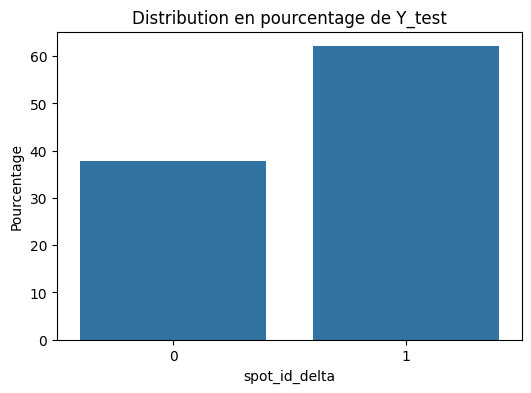

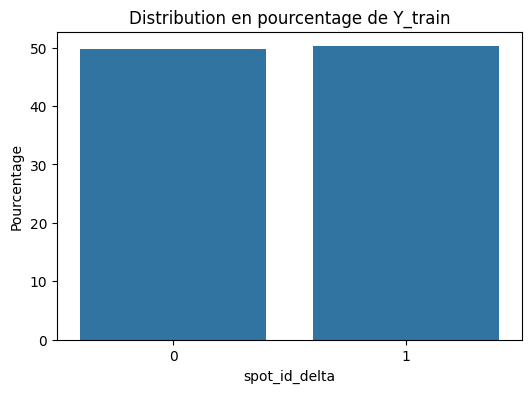

In [13]:
# Affichage des proportions en pourcentage pour Y_train et Y_test
print("Distribution en pourcentage de Y_train:")
print(Y_train['spot_id_delta'].value_counts(normalize=True) * 100)

print("\nDistribution en pourcentage de Y_test:")
print(Y_test['spot_id_delta'].value_counts(normalize=True) * 100)

# Graphique pour Y_test avec proportions
plt.figure(figsize=(6, 4))
prop_test = Y_test['spot_id_delta'].value_counts(normalize=True) * 100
sns.barplot(x=prop_test.index, y=prop_test.values)
plt.title('Distribution en pourcentage de Y_test')
plt.xlabel('spot_id_delta')
plt.ylabel('Pourcentage')
plt.show()

# Graphique pour Y_train avec proportions
plt.figure(figsize=(6, 4))
prop_train = Y_train['spot_id_delta'].value_counts(normalize=True) * 100
sns.barplot(x=prop_train.index, y=prop_train.values)
plt.title('Distribution en pourcentage de Y_train')
plt.xlabel('spot_id_delta')
plt.ylabel('Pourcentage')
plt.show()


La proportion de 0 dans `spot_id_delta` (indiquant que le prix Intraday est inférieur au prix SPOT) est significativement plus faible dans `Y_test` que dans `Y_train`. La dynamique du marché a considérablement changé, ce qui rend difficile pour les modèles entraînés sur des données antérieures de prédire avec précision le comportement du marché pendant la période de test. Alors que sur le trainign test la proportion est équilibré, on compte bien moins de cas où le prix intra jorunalier est infèrieur au prix spot dans el set `Y_test`.


### Distribution des features X_train et X_test

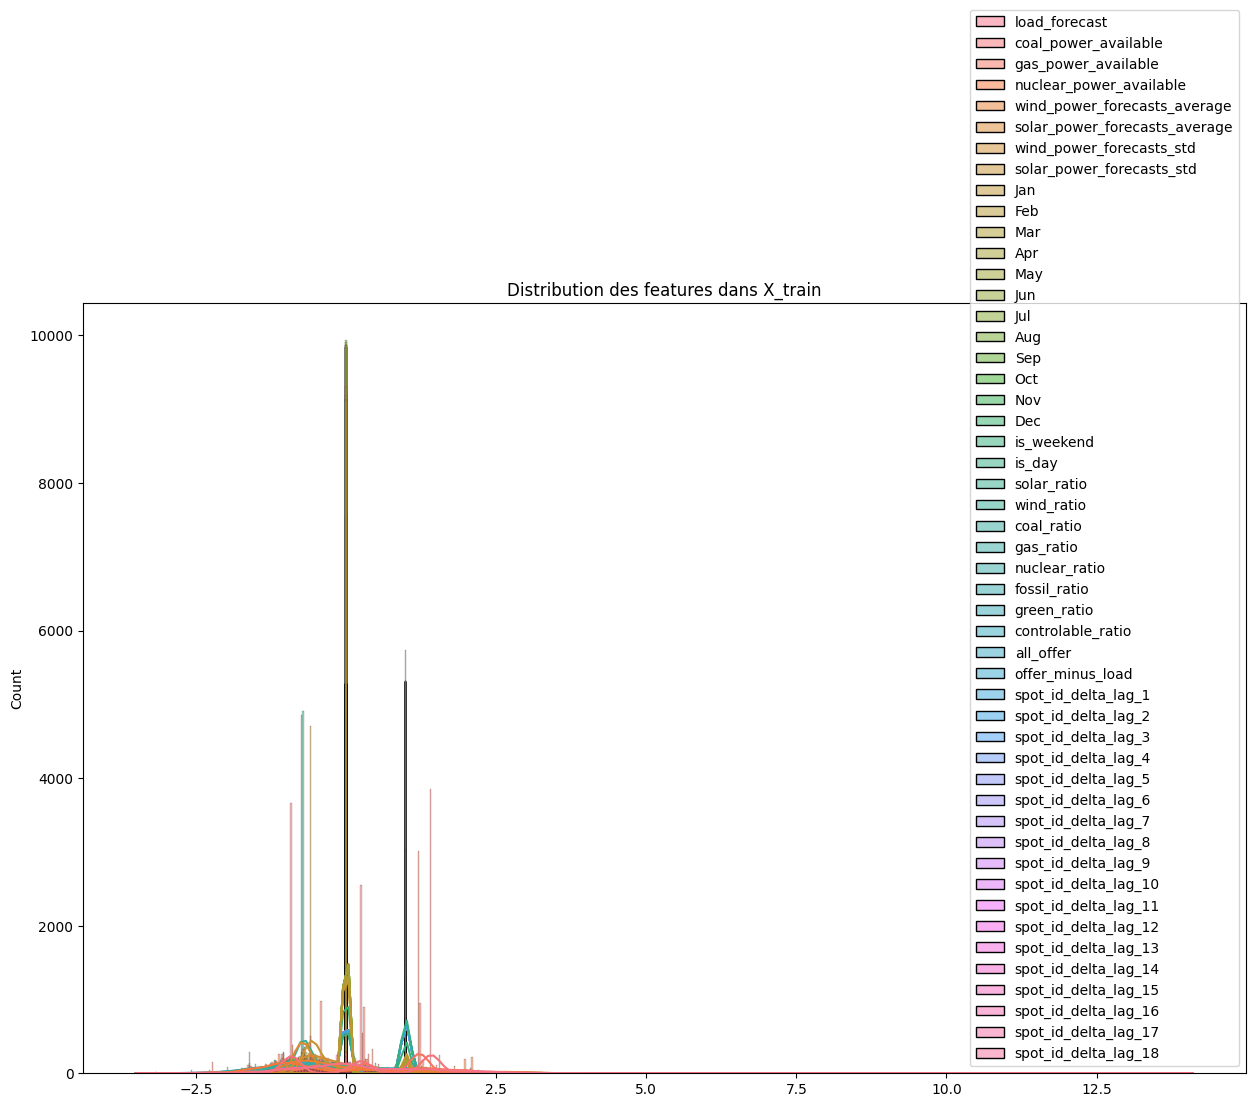

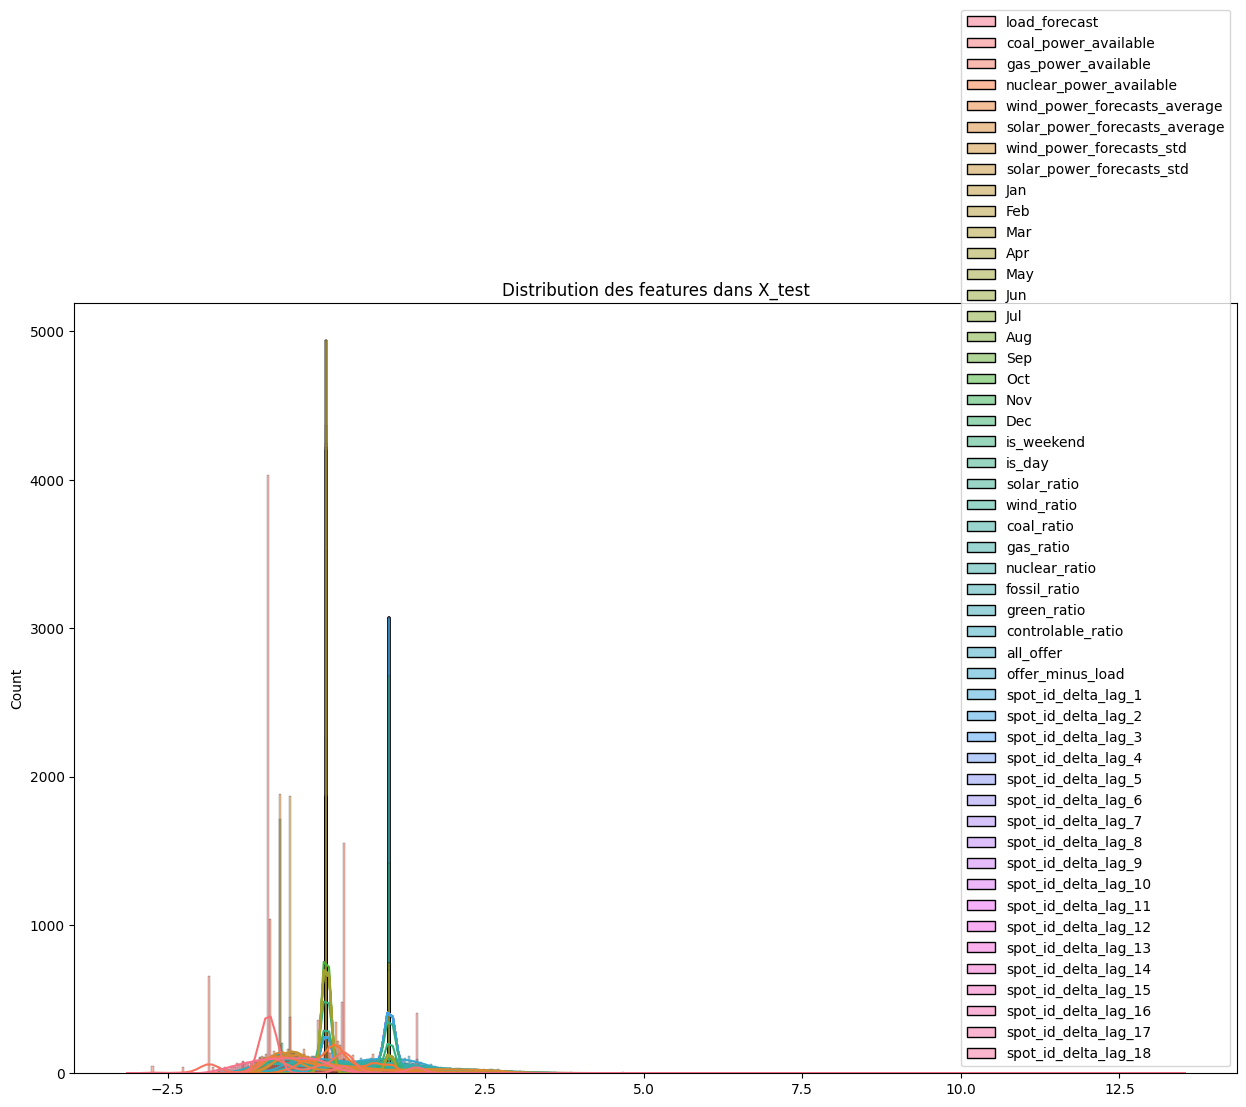

In [14]:
# Afficher la distribution des features dans X_train
plt.figure(figsize=(15, 10))
sns.histplot(data=X_train, kde=True)
plt.title('Distribution des features dans X_train')
plt.show()

# Afficher la distribution des features dans X_test
plt.figure(figsize=(15, 10))
sns.histplot(data=X_test, kde=True)
plt.title('Distribution des features dans X_test')
plt.show()

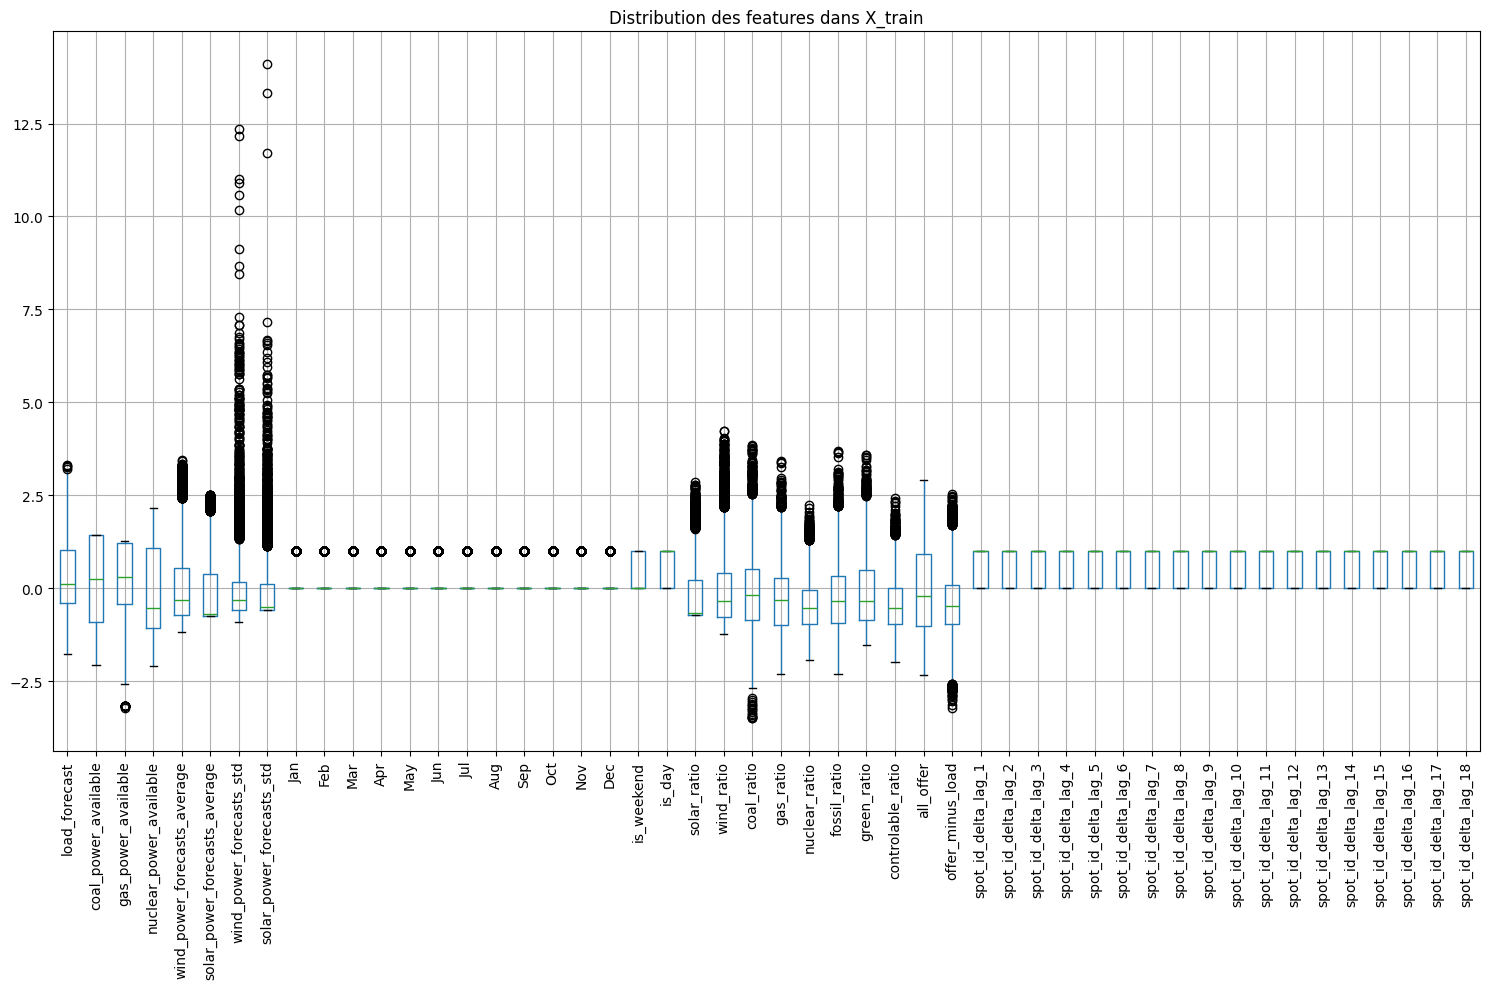

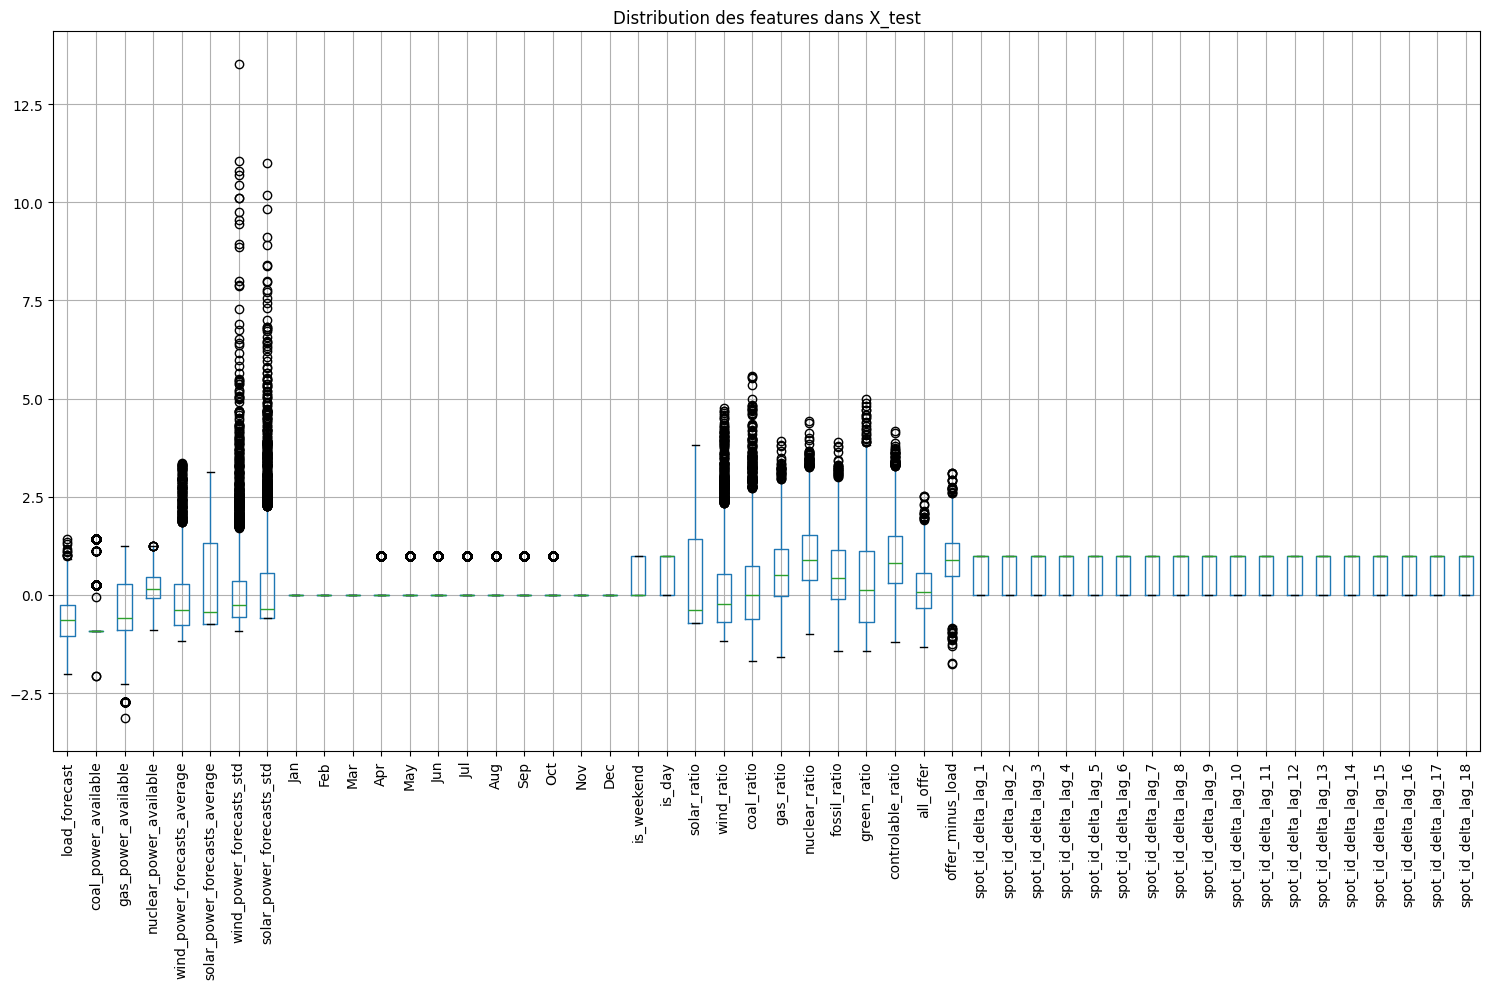

In [15]:
# Créer une boîte à moustaches pour chaque feature dans X_train
plt.figure(figsize=(15, 10))
X_train.boxplot()
plt.title('Distribution des features dans X_train')
plt.xticks(rotation=90)  # Pour une meilleure lisibilité des noms de features
plt.tight_layout()  # Ajuste les paramètres de sous-graphiques pour un espacement correct
plt.show()

# Créer une boîte à moustaches pour chaque feature dans X_test
plt.figure(figsize=(15, 10))
X_test.boxplot()
plt.title('Distribution des features dans X_test')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- Le set de test ne comprend pas les mois d'hiver, contrairement au set d'entraînement, ce qui conduit à des différences dans la distribution temporelle des données.
- Les features associées aux mois de janvier et février sont très présentes dans les données d'entraînement, alors qu'elles sont quasi absentes dans le test.

Ces variations temporelles entraînent une modification de la distribution des features, notamment :
- Des variations naturelles dans les variables liées à la charge électrique, comme "load_forecast".
- Des différences dans les ratios énergétiques (par exemple, solar_ratio, wind_ratio, etc.).
- Une distribution qui change pour les variables sensibles à la saisonnalité.

Ainsi, le modèle devra s'adapter à des conditions saisonnières qui n'ont pas été observées durant l'entraînement, ce qui peut impacter ses performances et nécessite une attention particulière lors de l'évaluation des résultats.


### Le caractère autorégressif des features

In [16]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

Y_train_series = Y_train['spot_id_delta'] if isinstance(Y_train, pd.DataFrame) else Y_train
Y_test_series  = Y_test['spot_id_delta'] if isinstance(Y_test, pd.DataFrame) else Y_test

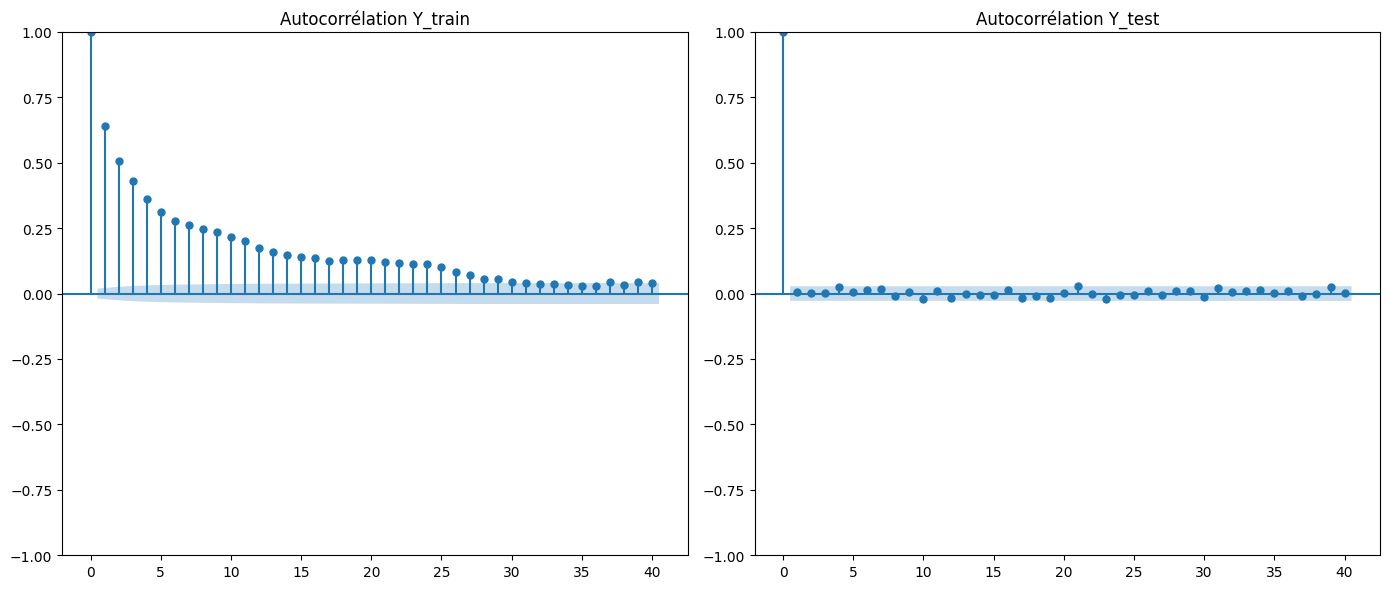

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plot_acf(Y_train_series, lags=40, ax=axes[0])
axes[0].set_title("Autocorrélation Y_train")

plot_acf(Y_test_series, lags=40, ax=axes[1])
axes[1].set_title("Autocorrélation Y_test")

plt.tight_layout()
plt.show()

L'analyse des graphiques d'autocorrélation met en lumière un défi majeur dans l'élaboration de notre modèle de prédiction des prix de l'énergie. En effet, nous constatons un contraste saisissant entre les schémas d'autocorrélation des ensembles d'entraînement et de test, révélant ainsi des pièges potentiels dans l'ingénierie des caractéristiques.

Pour l'ensemble d'entraînement (y_train), on observe une autocorrélation positive marquée qui décroît progressivement avec le temps. Ce comportement suggère l'existence de dépendances temporelles dans les fluctuations des prix spot. Fort de cette observation, nous avions intégré des caractéristiques retardées de delta spot (jusqu'à -18 sur les valeurs brutes), qui semblaient statistiquement significatives dans ces données.

Cependant, l'analyse de l'ensemble de test (y_test) présente une tout autre réalité : aucun schéma d'autocorrélation significatif n'apparaît au-delà du décalage 0. Cela explique pourquoi les modèles performants sur l'ensemble d'entraînement peinent à prédire les données de test.

Il est néanmoins intéressant de noter que, malgré cette inadéquation apparente, les modèles intégrant des caractéristiques rétrospectives surpassent ceux qui n'en disposent pas. Cela indique que, même si la structure d'autocorrélation ne se transfère pas parfaitement entre les ensembles, les variables retardées apportent des informations précieuses qui améliorent la précision des prédictions.


### Besoin de d'avantage de données

- Au niveau de la création de features et de l'imputation, nous avons obtenu de bons résultats, validés par le professeur.
- Cependant, il semble que nous manquions de données en quantité pour assurer une meilleure généralisabilité du modèle, ou bien de nouvelles features qui n'étaient pas accessibles dans le cadre du challenge.
- Par exemple, intégrer une variable température, et notamment détecter des anomalies par rapport aux normes saisonnières (comme une tempête de neige pouvant impacter le marché du SPOT), aurait apporté une dimension supplémentaire.
- De plus, des données complémentaires sur le prix du charbon ou du gaz auraient été très utiles pour enrichir l'analyse et améliorer les performances prédictives.


# Modélisation

## Réduction de dimension avec PCA
Nous avons dans un premier temps souhaité appliquer une réduction de dimension avec PCA sur nos données, notamment afin de pouvoir comprendre l'importance des features (51) et éventuellement en limiter le nombre.Nous avons retenu un nombre de composante nous permettant d'expliquer 80% de la variance, bien que ce seuil soit arbitraire, vous pourrez changer ce paramètre via "n_components" dans la cellule ci-dessous.

In [25]:
clusterer_pca = Clusterer() #n_components=0.8 par défaut
var_pca = clusterer_pca.explain_variance_summary()
var_pca['Total Variance Explained'] = var_pca['Explained Variance Ratio'].cumsum()
var_pca

,Explained Variance Ratio,Total Variance Explained
PC1,0.266525,0.266525
PC2,0.203001,0.469526
PC3,0.112634,0.582160
PC4,0.078280,0.660440
PC5,0.061593,0.722033
PC6,0.035344,0.757377
PC7,0.029855,0.787232
PC8,0.029068,0.816300


Comme nous le montre le graphique ci dessous, nous remarquons que passé 5 composantes, l'ajout d'une composante supplémentaire ne permet pas d'expliquer une grande partie de la variance.

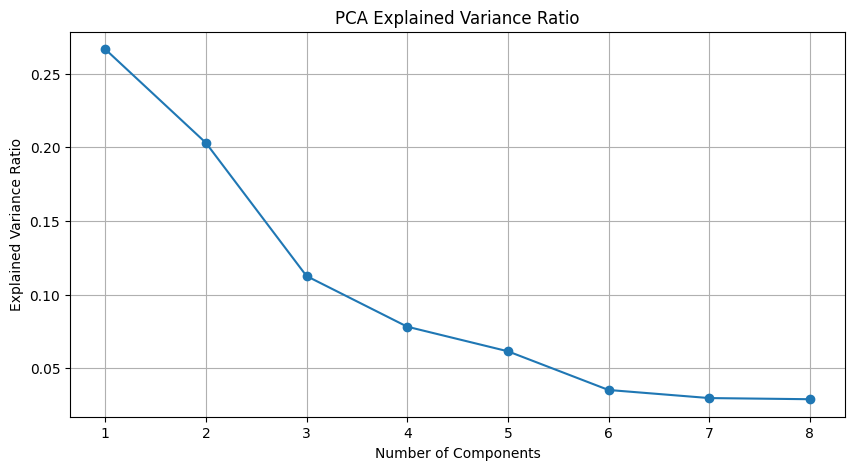

In [19]:
clusterer_pca.anaylize_pca()

Cette heatmap nous montre que la plupart des features sont regroupées dans les mêmes composantes, ce qui nous permet de conclure que la plupart des features sont corrélées entre elles. Cela est dû au fait que nous avons beaucoup de features liées économiquement entre elles (les variables lagées par exemple, ou les indication de mois, ...). Nous avons alors pensé à identifier des configurations de features qui pourraient être redondantes et donc utiles pour le modèle. Cela nous permettrait de modéliser plus finement les données et de réduire le nombre de features à traiter. Egalement, en détectant des changements de régimes à travers le temps, nous pourrions entraîner différents modèles pour chaque période, ce qui pourrait améliorer la performance globale du modèle.
C'est ce que nous allons essayer de faire dans la suite de ce notebook.

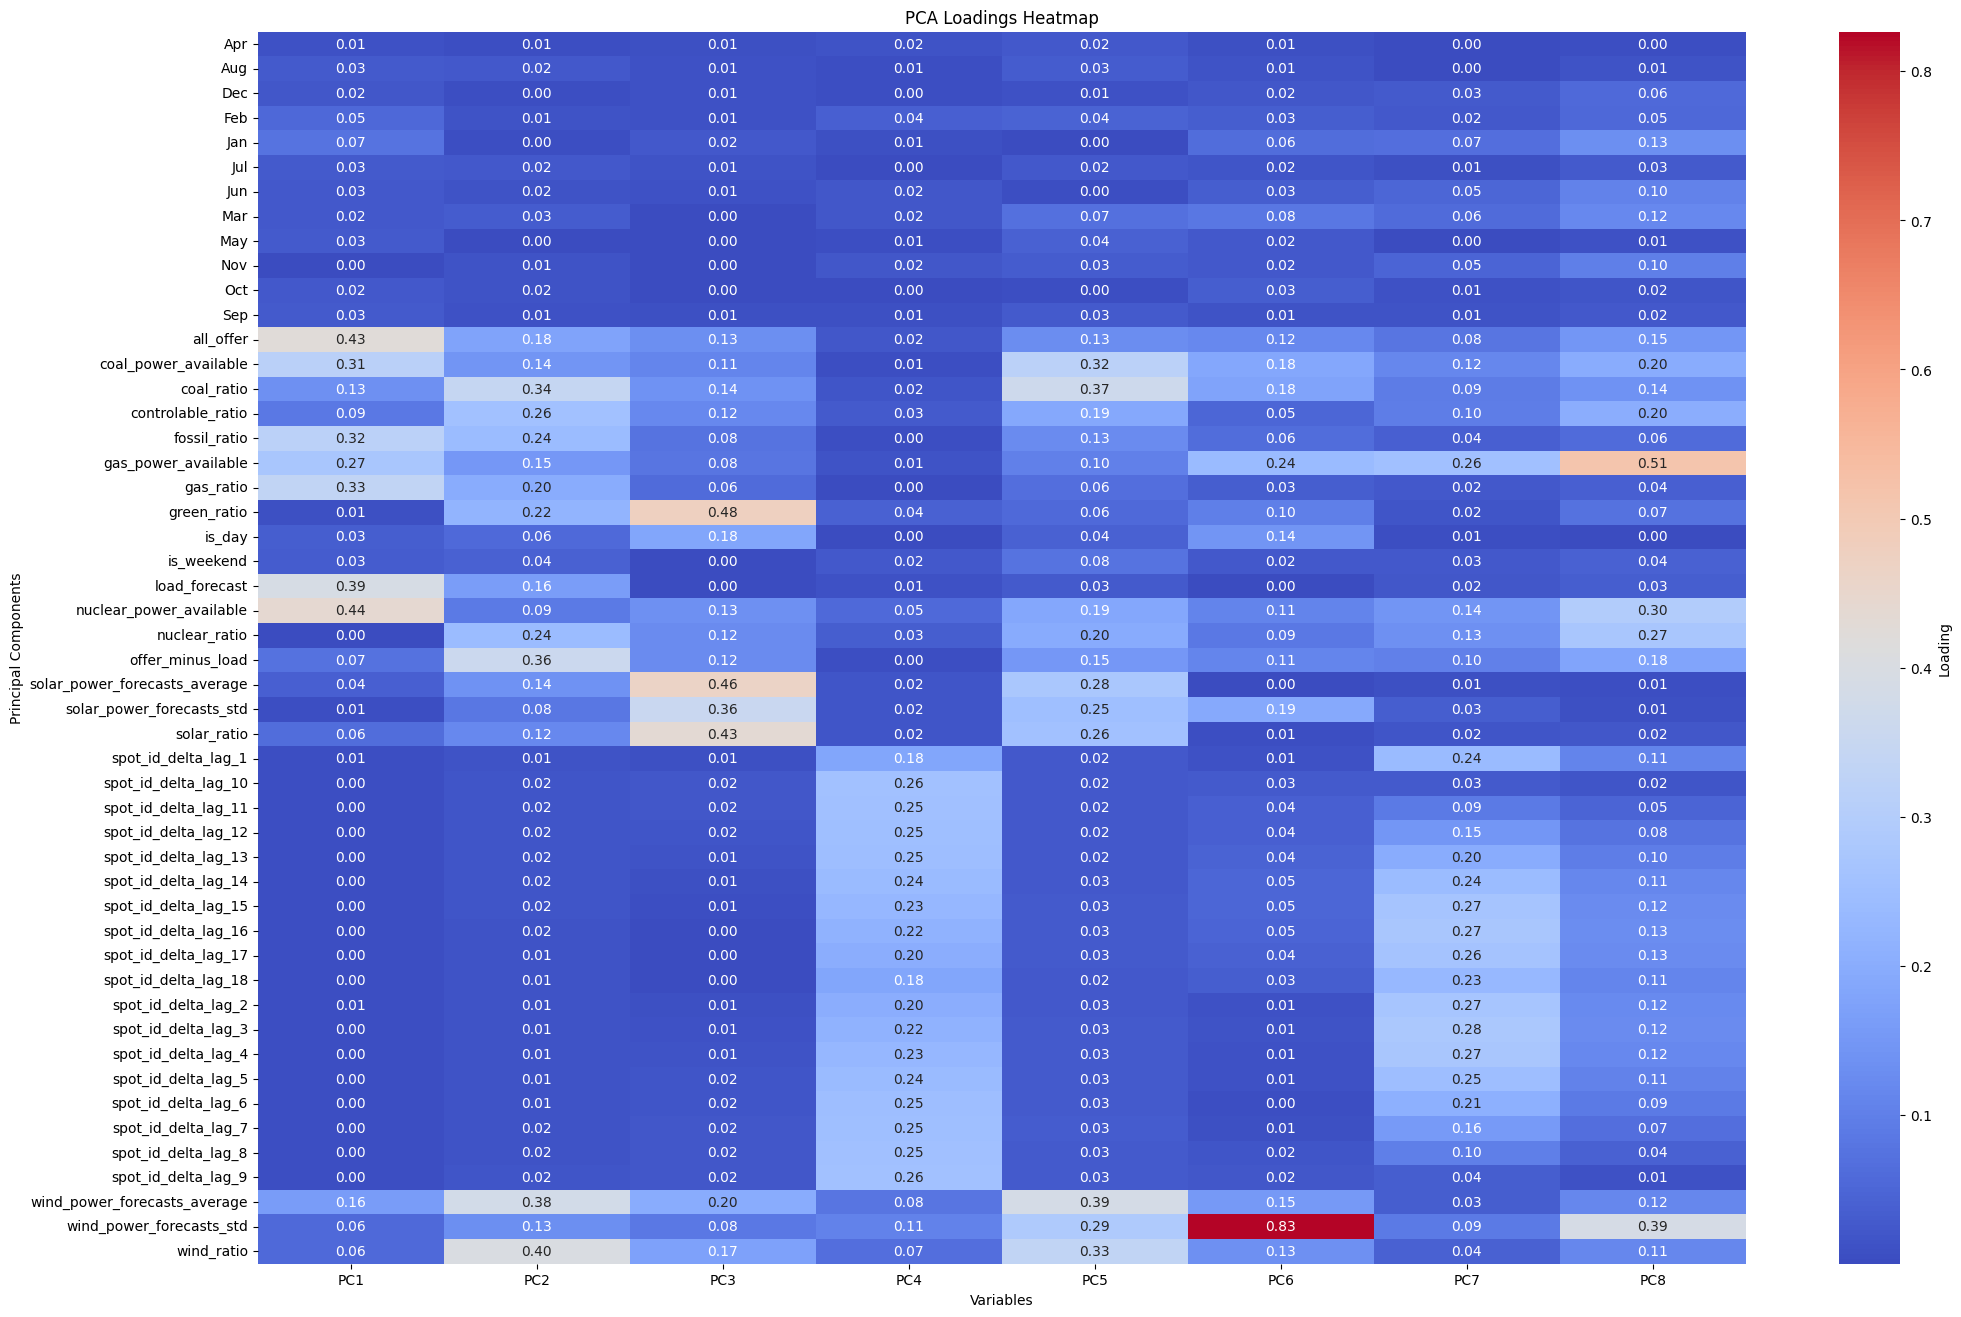

In [20]:
clusterer_pca.plot_loadings_heatmap()

## Création de clusters

### Pertinence de l'approche

Notre première approche consiste à utiliser des techniques de clustering pour identifier différents "régimes" ou "états" du marché de l'électricité. Le marché énergétique est caractérisé par une forte variabilité liée aux conditions météorologiques, à la saisonnalité et aux différents mix énergétiques disponibles. En segmentant nos données en clusters distincts, nous pourrons identifier des patterns spécifiques où la relation entre prix spot et prix intraday suit des logiques différentes. Par exemple, nous pourrons isoler les périodes dominées par les énergies renouvelables, les moments de forte demande, ou les transitions jour/nuit. Cette approche nous permettra non seulement d'améliorer la précision de nos prédictions en développant potentiellement des modèles spécialisés par cluster, mais aussi de mieux comprendre les mécanismes fondamentaux qui déterminent quand le prix spot dépasse le prix intraday et inversement.

### Description de l'approche


Dans notre analyse, nous avons développé une approche structurée basée sur la classe `Clusterer` que vous pouvez trouver dans le fichier `clusterer.py`. Cette classe encapsule toute la logique nécessaire pour réaliser notre clustering du marché de l'électricité.

La classe `Clusterer` offre plusieurs fonctionnalités clés :

1. Elle gère l'importation et le prétraitement des données (train et test)
2. Elle applique une réduction dimensionnelle via PCA avant le clustering
3. Elle permet d'utiliser au choix deux algorithmes de clustering : KMeans ou GaussianMixture (nous avons retenu ces deux algorithmes car ils assignent toutes les observations à un cluster, contrairement à DBSCAN, que nous avions initialement essayé mais qui peut laisser certaines observations non assignées)
4. Elle intègre des méthodes d'évaluation pour déterminer le nombre optimal de clusters via des scores de silhouette et, dans le cas de GaussianMixture, des critères BIC et AIC
5. Elle assure la cohérence entre les phases d'entraînement et de test en appliquant la même transformation PCA

Cette approche orientée objet présente plusieurs avantages pour notre projet. Elle permet une organisation modulaire du code qui facilite les tests de différentes configurations de clustering. La classe encapsule toute la logique métier, ce qui rend notre code principal plus lisible et maintenable. De plus, les dataclasses `SampleType` et `ClusterType` apportent une couche d'abstraction qui rend le code plus robuste et moins sujet aux erreurs. Cette structure nous permet d'explorer efficacement différentes hypothèses sur la segmentation du marché de l'électricité, tout en gardant un code cohérent et facilement extensible.

### Utilisation de la méthode Assert Cluster Modèle

Cette méthode nous permet de mettre en oeuvre des techniques nous permettant de choisir le bon nombre de clusters. Nous avons utilisé le score de silhouette et les critères BIC et AIC pour évaluer la qualité de nos clusters. Ces deux derniers ne sont applicables que dans le cas de GaussianMixture, mais ils sont particulièrement pertinents pour évaluer la qualité des clusters dans le cadre de modèles probabilistes. Le score de silhouette, quant à lui, est applicable à tous les types de clustering et nous aide à comprendre comment les points sont regroupés dans l'espace des caractéristiques. Ces techniques nous aident à déterminer le nombre optimal de clusters en fonction de la structure des données et des caractéristiques des différents régimes du marché de l'électricité.

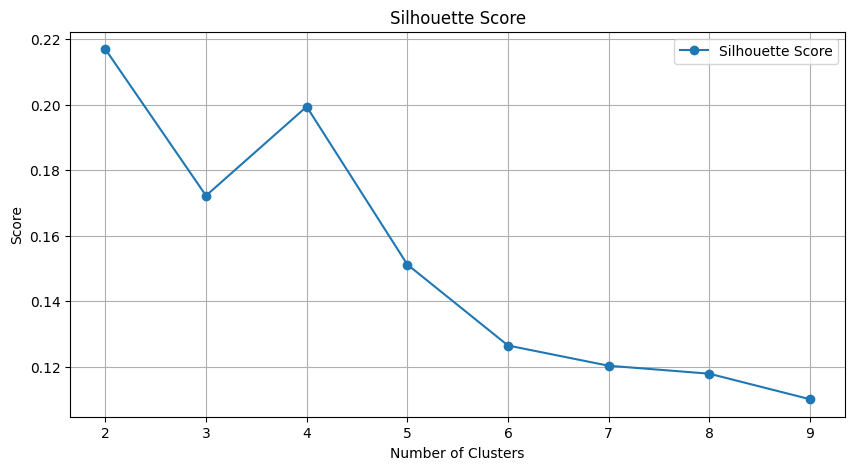

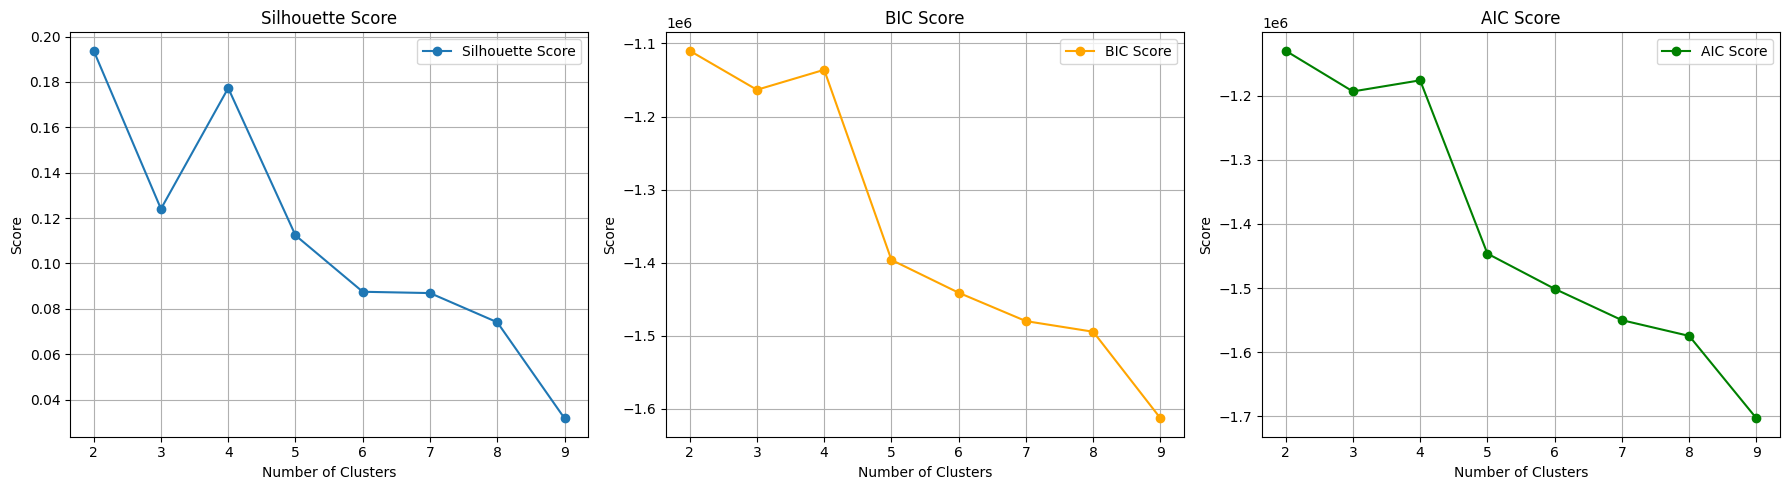

In [26]:
from clusterer import Clusterer, ClusterType

clusterer_assert = Clusterer(
    cluster_model=ClusterType.kmeans,
)

k_range = range(2, 10)
fig_kmeans = clusterer_assert.assert_cluster_model(ClusterType.kmeans, k_range)

fig_kmeans.show()

# Si vous voulez aussi tester GaussianMixture
fig_gmm = clusterer_assert.assert_cluster_model(ClusterType.gaussian_mixture, k_range)
fig_gmm.show()

### Résultats
Comme nous pouvons le voir sur ces deux images, les clusters perdent en score passé un certain nombre de clusters. Cela signifie que nous avons atteint un point de saturation où l'ajout de nouveaux clusters n'apporte pas d'informations supplémentaires significatives. En effet, le score de silhouette diminue au-delà de 3 clusters (que nous avons alors retenu comme valeur par défaut au sein de la classe), ce qui indique que les points deviennent moins bien séparés et que la structure des données devient plus complexe à interpréter. De plus, les critères BIC et AIC montrent une tendance similaire dans le cas du gaussian mixture, suggérant que la complexité du modèle n'est pas justifiée par une amélioration significative de l'ajustement des données.


### Sur le choix du nombre de clusters
Les illustrations ci-dessous permettent de visualiser au moyen d'une PCA(3) la séparation des clusters obtenus par le modèle de clustering choisi.
Vous remarquerez qu'en augmentant le nombre de clusters, la séparation entre les clusters devient de plus en plus difficile à distinguer. En effet, au-delà de 3 clusters, la séparation devient moins nette et les points commencent à se chevaucher, ce qui complique l'interprétation des résultats. Cela souligne l'importance de choisir un nombre de clusters qui reflète réellement la structure sous-jacente des données, plutôt que d'opter pour un nombre arbitraire basé uniquement sur des critères statistiques.
Egalement, en augmentant le nombre de clusters, certaines valeurs se voient attribuées à des clusters de faible tailles, ce qui pourrait nous gêner plus tard dans l'analyse, rendant notamment l'entraînement de modèle impossible faute de suffisamment de données.

In [27]:
clusterer_visu_cluster = Clusterer(n_cluster=3, cluster_model=ClusterType.kmeans) 
#vous pouvez ici changer le nombre de clusters ou le modèle de clustering (via ClusterType.kmeans ou ClusterType.gaussian_mixture)

# Utiliser PCA pour réduire à 3 dimensions pour la visualisation
pca_3d = PCA(n_components=3, random_state=42)
X_train_3d = pca_3d.fit_transform(clusterer_visu_cluster.X_train.drop(columns=['Cluster']))
X_test_3d = pca_3d.transform(clusterer_visu_cluster.X_test.drop(columns=['Cluster']))

# Visualiser les clusters pour les données d'entraînement
fig = px.scatter_3d(
    x=X_train_3d[:, 0],
    y=X_train_3d[:, 1],
    z=X_train_3d[:, 2],
    color=clusterer_visu_cluster.X_train['Cluster'],  # Les labels de cluster sont déjà dans X_train
    title="3D PCA of Clusters for training data",
    labels={'x': 'PCA1', 'y': 'PCA2', 'z': 'PCA3'},
    color_discrete_sequence=px.colors.qualitative.Plotly,
    opacity=0.7,
)
fig.update_traces(marker=dict(size=3))
fig.update_layout(scene=dict(aspectmode='cube', 
                            xaxis=dict(title_font=dict(size=15)), 
                            yaxis=dict(title_font=dict(size=15)), 
                            zaxis=dict(title_font=dict(size=15))), 
                 width=1000, height=800)
fig.show()

# Visualiser les clusters pour les données de test
fig = px.scatter_3d(
    x=X_test_3d[:, 0],
    y=X_test_3d[:, 1],
    z=X_test_3d[:, 2],
    color=clusterer_visu_cluster.X_test['Cluster'],  # Les labels de cluster sont déjà dans X_test
    title="3D PCA of Clusters for testing data",
    labels={'x': 'PCA1', 'y': 'PCA2', 'z': 'PCA3'},
    color_discrete_sequence=px.colors.qualitative.Plotly,
    opacity=0.7,
)
fig.update_traces(marker=dict(size=3))
fig.update_layout(scene=dict(aspectmode='cube', 
                            xaxis=dict(title_font=dict(size=15)), 
                            yaxis=dict(title_font=dict(size=15)), 
                            zaxis=dict(title_font=dict(size=15))), 
                 width=1000, height=800)
fig.show()

### Interprétation de l'analyse par clustering

L'analyse par clustering révèle trois aspects majeurs sur les derniers graphs :

1. **Structure des clusters**
- L'analyse suggère 3 clusters distincts représentant différents configurations de marché
- La visualisation 3D PCA montre une séparation claire entre ces groupes, ils sont assez proches les uns des autres, mais suffisamment distincts pour être interprétés comme des régimes différents
- Les clusters sont bien séparés, ce qui indique que les données sont bien structurées et que les clusters sont significatifs
- Les clusters semblent stables entre les jeux d'entraînement et de test

2. **Implications pratiques**
- Les patterns identifiés correspondent probablement aux périodes :
    - De forte production renouvelable 
    - De pics de demande
    - De transition jour/nuit

3. **Application**
- Cette segmentation peut servir à développer des modèles spécialisés par cluster
- La stabilité des clusters valide l'approche pour les prédictions futures
- Les frontières nettes entre clusters suggèrent des comportements de marché distincts

Cette approche offre une base solide pour améliorer la précision des prédictions de prix.


## Classification des clusters

Nous avons réutiliser notre précédente classe `Clusterer` pour créer une nouvelle classe `Model` qui va nous permettre de classifier nos clusters. Comme évoqué précédemment, le but est d'entraîner un modèle de classification pour chaque clusters identifiés. Cette dernière intègre toute la pipeline de traitement des données, de réduction de dimension et de clusterisation, du fait de l'héritage. Finalement, elle permet d'entraîner un modèle de classification sur les données d'entraînement et de prédire les classes ([0,1] dans notre cas) sur les données de test.

In [29]:
from model import Model
model = Model()

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


### Regression Logistique par cluster

Dans notre première approche, nous appliquons une stratégie segmentée en exploitant les clusters identifiés sur le marché de l'électricité. L'idée est simple mais puissante : plutôt que d'utiliser un modèle unique pour tous les types de marchés, nous entraînons une régression logistique spécifique sur chaque cluster. Chaque modèle peut ainsi se spécialiser dans les particularités de son segment de marché. Nous combinons ensuite les prédictions de ces modèles spécialisés pour obtenir notre résultat global, mesuré par la balanced accuracy. Cette approche "diviser pour mieux régner" nous permet de tester si la compréhension des différents régimes du marché améliore notre capacité à prédire quand le prix spot dépassera le prix intraday.

In [30]:
classifiersmodel = model.classifier_models
print(classifiersmodel)

{ExtraTreesClassifier(random_state=42): np.float64(0.5010985827707084), AdaBoostClassifier(random_state=42): np.float64(0.4985032294885715), LogisticRegression(random_state=42): np.float64(0.5025666342460235)}


La régression logistique avec clusterisation obtient un balanced accuracy de 0.5026, contre 0.5024 pour le benchmark.
Cette très légère amélioration (+0.0002) suggère que :
- La clusterisation n'apporte qu'une amélioration marginale des performances
- Les patterns identifiés par clustering ne sont pas suffisamment distinctifs pour améliorer significativement les prédictions
- La complexité ajoutée par la clusterisation ne justifie peut-être pas le gain minime en performance

Ces résultats indiquent que la dynamique du marché de l'électricité reste difficile à prédire, même en segmentant les données en régimes distincts

### ExtraTreesClassifier

L'ExtraTreesClassifier est une méthode d'ensemble qui améliore les forêts aléatoires en ajoutant plus de randomisation dans la sélection des seuils lors des divisions d'arbres. Ce modèle est pertinent pour nos données de prix spot d'électricité car il capture efficacement les relations non linéaires complexes entre les multiples variables énergétiques (disponibilité des sources d'énergie, prévisions météorologiques, charge prévue). Particulièrement adapté à la volatilité du marché électrique avec ses pics occasionnels, ExtraTrees résiste bien au surapprentissage tout en fournissant des scores d'importance des caractéristiques qui nous aident à identifier les facteurs clés influençant les variations de prix.

A noté que nous avons gardé la logique de pré clusterisation, puis application du modèle sur chaque cluster en efnin concaténation des résualtats ici également.

In [31]:
classifiersmodel = model.classifier_models
print(classifiersmodel)

{ExtraTreesClassifier(random_state=42): np.float64(0.5010985827707084), AdaBoostClassifier(random_state=42): np.float64(0.4985032294885715), LogisticRegression(random_state=42): np.float64(0.5025666342460235)}


L'ExtraTreesClassifier obtient un score de balanced accuracy de 0.5010, légèrement en dessous du benchmark de 0.5024, ce qui indique qu'il ne parvient pas à capturer efficacement les patterns dans les données de prix spot de l'électricité. Bien que théoriquement adapté aux données complexes, l'ExtraTreesClassifier pourrait ne pas être optimal pour ce problème spécifique. Cette performance décevante pourrait résulter de plusieurs facteurs : la structure particulière des données énergétiques, la nature temporelle des séries de prix, ou simplement une inadéquation entre l'approche d'ensemble très randomisée et les caractéristiques sous-jacentes du problème de prédiction des écarts de prix. Une exploration plus approfondie des données et l'essai d'autres algorithmes seraient nécessaires pour identifier une meilleure approche.

### AdaBoostClassifier

AdaBoostClassifier (Adaptive Boosting) est un algorithme d'ensemble qui combine plusieurs classifieurs faibles pour former un classifieur fort. Il fonctionne en entraînant séquentiellement des modèles, où chaque nouveau modèle se concentre davantage sur les exemples mal classifiés par les modèles précédents. Cette méthode attribue des poids aux observations et les ajuste après chaque itération, augmentant l'importance des exemples difficiles à classifier.

Ce modèle peut être pertinent pour la prédiction des prix spot de l'électricité car ce marché présente des dynamiques complexes avec des événements rares mais significatifs, comme les pics de prix. La capacité du modèle à se concentrer progressivement sur les cas difficiles pourrait lui permettre de mieux capturer ces événements exceptionnels qui influencent fortement les variations de prix. De plus, sa nature adaptative le rend potentiellement plus sensible aux subtiles relations entre les différentes features.

In [32]:
classifiersmodel = model.classifier_models
print(classifiersmodel)

{ExtraTreesClassifier(random_state=42): np.float64(0.5010985827707084), AdaBoostClassifier(random_state=42): np.float64(0.4985032294885715), LogisticRegression(random_state=42): np.float64(0.5025666342460235)}


L'AdaBoostClassifier a obtenu un score de 0.5025, surpassant à peine le benchmark. Cette amélioration marginale pourrait être attribuée à sa capacité d'adaptation qui se concentre progressivement sur les exemples difficiles, caractéristique potentiellement utile pour les marchés volatils de l'électricité.

### Long Short Term memory Model (LSTM)


Le LSTM est un type spécial de réseau de neurones récurrents (RNN) conçu pour traiter et prédire des séquences de données. Contrairement aux réseaux de neurones traditionnels, le LSTM dispose de cellules mémoire capables de retenir des informations sur de longues périodes, décidant quelles informations conserver et lesquelles oublier. Cette architecture comprend trois "portes" principales: une porte d'oubli, une porte d'entrée et une porte de sortie, qui régulent le flux d'information à travers le réseau.

Le LSTM est particulièrement adapté à notre problème de prédiction des variations de prix spot de l'électricité pour plusieurs raisons. Les prix énergétiques sont influencés par des tendances à court terme (demande journalière) et des patterns à long terme (saisonnalité, évolutions du marché), que le LSTM peut capturer efficacement grâce à sa mémoire sélective. Notre modèle est configuré avec une couche LSTM initiale de 128 neurones suivie d'une seconde couche de 32 neurones, permettant de traiter les différentes échelles temporelles présentes dans les données.

Une caractéristique importante de notre implémentation est l'ajout d'une couche de sortie avec activation sigmoïde, qui transforme le problème de régression en classification binaire. Cette configuration permet au modèle de prédire si le prix spot dépassera ou non un certain seuil, offrant une approche plus robuste face à la volatilité extrême du marché de l'électricité, où la direction du mouvement de prix peut être plus prévisible que sa magnitude exacte.

In [33]:
print(f"Score global du LSTM: {model.lstm_global_score}")

Score global du LSTM: 0.4981926149407847


Malgré la conception théoriquement adaptée de notre modèle LSTM pour la prédiction des variations de prix spot d'électricité, les résultats obtenus sont malheureusement médiocres, avec un score global de balanced accuracy de seulement 0.49110301196903017, ce qui est inférieur à un lancer de pièce...

Cette contre-performance est d'autant plus surprenante que le modèle semblait parfaitement conçu pour ce type de données temporelles. Il est important de noter que même après avoir testé diverses modifications des hyperparamètres et implémenté un early stopping pour éviter le surapprentissage (l'accuracy sur les données d'entraînement atteignant environ 80%), les performances sur les données de test sont restées décevantes.


### Test en masse sur un ensemble de classifier

Cette fonction nous permet de tester en masse un ensemble de classifieurs sur nos données. Nous avons utilisé cette fonction pour évaluer la performance de plusieurs classifieurs sur nos données d'entraînement et de test. Cela nous a permis de comparer rapidement les performances de différents modèles et d'identifier ceux qui fonctionnent le mieux sur notre problème spécifique. Attention toutefois, les résultats observés ci-dessous dépendent largement de la seed ce qui nous empêche de tirer des conclusions définitives sur la performance de chaque classifieur. Il est donc important de garder à l'esprit que ces résultats sont indicatifs et ne permettent en aucun cas de valider la supériorité d'un modèle vis à vis des autres.

In [34]:
model.assert_best_classifier()

,Classifier,Score
0,DummyClassifier,0.545687
1,GaussianProcessClassifier,0.513327
2,KNeighborsClassifier,0.512112
3,NearestCentroid,0.511542
4,BernoulliNB,0.510186
5,LabelSpreading,0.507456
6,LabelPropagation,0.507358
7,ExtraTreeClassifier,0.505444
8,SGDClassifier,0.505346
9,GaussianNB,0.504831


# Analyse de notre relatif échec

**Différences de distribution entre données d'entraînement et de test**

L'examen approfondi de nos ensembles de données révèle une disparité significative entre les distributions de nos données d'entraînement et de test. Cette discordance affecte non seulement les variables explicatives (features X) mais également la variable cible (Y). En effet, la distribution des prix spot et leurs variations diffèrent substantiellement entre ces deux ensembles, reflétant probablement des conditions de marché distinctes entre les périodes correspondantes. Ces différences sont inhérentes aux marchés énergétiques, qui évoluent rapidement en fonction des saisons, des événements météorologiques, des changements réglementaires et des tendances macroéconomiques. Un modèle entraîné sur une distribution particulière se trouve ainsi confronté à une réalité différente lors de la phase de test, expliquant largement l'écart entre nos performances d'entraînement prometteuses et les résultats décevants sur les données de test.

**Défis liés à la temporalité des données**

La dimension temporelle de nos données constitue un obstacle majeur à la performance prédictive. Nos ensembles d'entraînement et de test correspondent à des périodes chronologiques différentes, chacune avec ses propres caractéristiques contextuelles. Cette séparation temporelle implique que certains facteurs d'influence peuvent être présents dans une période mais absents ou transformés dans l'autre. Par exemple, la relation entre la disponibilité des énergies renouvelables et les prix spot peut varier significativement selon les périodes de l'année ou les années elles-mêmes, à mesure que le mix énergétique évolue. De même, les comportements de consommation et les stratégies des acteurs du marché changent au fil du temps, modifiant les dynamiques sous-jacentes que nos modèles tentent de capturer. Cette non-stationnarité fondamentale des données énergétiques représente un défi considérable pour tout modèle prédictif, même les plus sophistiqués comme le LSTM.